# Knowledge-drive Active Learning - Experiment on the XOR problem

#### Importing libraries

In [1]:
import os

import tqdm
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

#### Generating data for the xor problem

In [2]:
tot_points = 10000
first_points = 10
n_points = 5
n_iterations = 198
seeds = range(5)
x = np.random.uniform(size=(tot_points, 2))
y = np.ndarray.astype(((x[:, 0] > 0.5) & (x[:, 1] < 0.5)) |
                      ((x[:, 1] > 0.5) & (x[:, 0] < 0.5)), float)
pos_idx = np.where(y > 0.5)
neg_idx = np.where(y < 0.5)

#### Visualizing xor data

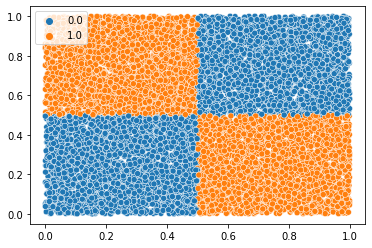

In [3]:
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y)
plt.show()

#### Defining constraints as product t-norm of the FOL rule expressing the XOR

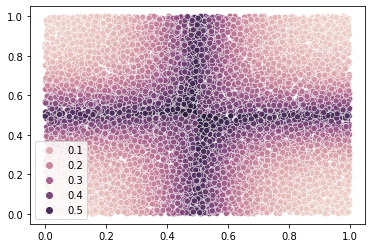

In [4]:
def steep_sigmoid(input, k=10, b=0.5):
    output = 1 / (1 + torch.exp(-k*(input-b)))
    return output

# (x1 & ~x2) | (x2 & ~x1) <=> f
# => f -> (x1 & ~x2) | (~x1 & x2)
# => (f * ((1 - (x1 * (1 - x2))) * (1 - (x2 * (1 - x1))))

# (x1 & ~x2) | (~x1 & x2) -> f
# => (1 - f) * (1 - * ((1 - (x1 * (1 - x2)) * (1 - (x2 * (1 - x1)))
def calculate_constraint_loss(x_continue: torch.Tensor, f: torch.Tensor) -> torch.Tensor:
    # discrete_x = (x_continue > 0.5).float()
    discrete_x = steep_sigmoid(x_continue).float()
    x1 = discrete_x[:, 0]
    x2 = discrete_x[:, 1]
    cons_loss1 = f * ((1 - (x1 * (1 - x2))) * (1 - (x2 * (1 - x1))))
    cons_loss2 = (1 - f) * (1 - ((1 - (x1 * (1 - x2))) * (1 - (x2 * (1 - x1)))))
    return cons_loss1 + cons_loss2

x_t = torch.as_tensor(x, dtype=torch.float)
y_t = torch.as_tensor(y, dtype=torch.float)

cons_loss = calculate_constraint_loss(x_t, y_t)
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=cons_loss)
plt.show()


#### Creating a simple MLP

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input_x: torch.Tensor):
        hidden = self.fc1(input_x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


#### Defining the training loop

In [6]:
def train_loop(network: MLP, train_data: torch.Tensor, train_labels: torch.Tensor,
               train_idx: list, epochs: int = 100, visualize_loss: bool = False):
    train_idx = np.asarray(train_idx)
    train_data = train_data[train_idx, :]
    train_labels = train_labels[train_idx].squeeze()
    optim = torch.optim.AdamW(network.parameters(), lr=1e-2)
    loss = torch.nn.BCELoss(reduction="none")
    l_train = []
    for j in range(epochs):
        optim.zero_grad()
        p_t = network(train_data).squeeze()
        s_l = loss(p_t, train_labels)
        s_l = s_l.mean()
        s_l.backward()
        optim.step()
        l_train.append(s_l.item())
    if visualize_loss:
        sns.lineplot(data=l_train)
        plt.ylabel("Loss"), plt.xlabel("Epochs")
        plt.title("Training loss variations in function of the epochs")
        plt.show()
    return l_train

#### Few epochs with n randomly selected data

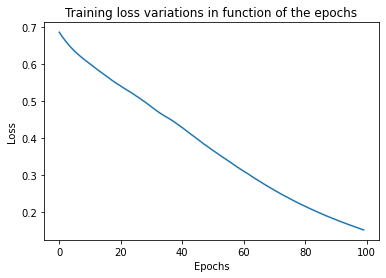

In [7]:
net = MLP(2, 100)
first_idx = np.random.randint(0, x.shape[0] - 1, first_points).tolist()
first_loss = train_loop(net, x_t, y_t, first_idx, visualize_loss=True)


#### Constrained Active learning strategy
We take n elements which are the one that most violates the constraints and are among available idx

In [8]:
def cal_selection(labelled_idx: list, c_loss: torch.Tensor, n_p: int) -> list:
    c_loss[torch.as_tensor(labelled_idx)] = -1
    cal_idx = torch.argsort(c_loss, descending=True).tolist()[:n_p]
    return cal_idx

#### Active Learning with KAL strategy

C:\Users\gabri\Anaconda3\envs\fsc\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


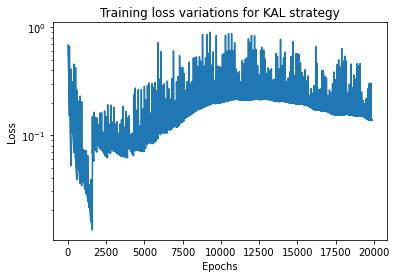

In [9]:
with torch.no_grad():
    p_t = net(x_t).squeeze()
p = p_t.numpy()
acc = (p_t > 0.5).eq(y_t).sum().item() / y_t.shape[0] * 100
with torch.no_grad():
    preds_t = net(x_t).squeeze()
accuracy = (preds_t > 0.5).eq(y_t).sum().item() / y_t.shape[0] * 100
cons_loss = calculate_constraint_loss(x_t, preds_t)
sup_loss = torch.nn.BCELoss(reduction="none")(preds_t, y_t)

accuracies = [accuracy]
available_idx = [*range(tot_points)]
used_idx = first_idx

losses = first_loss
pbar = tqdm.notebook.tqdm(range(n_iterations))
for n in range(1, n_iterations + 1):
    available_idx = list(set(available_idx) - set(used_idx))

    active_idx = cal_selection(used_idx, cons_loss, n_points)
    used_idx += active_idx

    losses += train_loop(net, x_t, y_t, used_idx)

    with torch.no_grad():
        preds_t = net(x_t).squeeze()
    accuracy = (preds_t > 0.5).eq(y_t).sum().item() / y_t.shape[0] * 100
    cons_loss = calculate_constraint_loss(x_t, preds_t)
    sup_loss = torch.nn.BCELoss(reduction="none")(preds_t, y_t)
    accuracies.append(accuracy)
    pbar.set_description(f"{n}/{n_iterations} it, Acc: {accuracy:.1f}, "
                         f"Sup loss: {sup_loss.mean().item():.2f}, n points: {len(used_idx)}")
    pbar.update()

pbar.close()
sns.lineplot(data=losses)
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title(f"Training loss variations for KAL strategy")
plt.show()


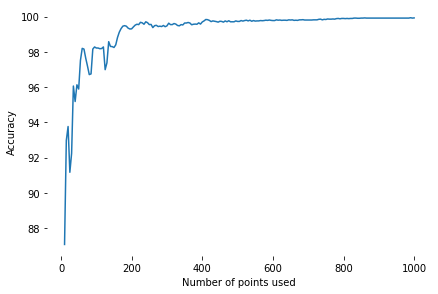

In [16]:
used_points = [first_points + n_points * i for i in range(n_iterations + 1)]
sns.lineplot(x=used_points, y=accuracies)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.ylabel("Accuracy")
plt.xlabel("Number of points used")
plt.show()